In [1]:
import torch as t
import torch.nn as nn
import torch.nn.functional as F
import torchvision as tv
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as mpl
%matplotlib inline

In [2]:
device = t.device("cuda" if t.cuda.is_available() else "cpu")

In [3]:
train_data = tv.datasets.MNIST(
    './MNIST_data',train = True,transform = transforms.ToTensor(),download = True)
test_data = tv.datasets.MNIST(
    './MNIST_data',train = False,transform = transforms.ToTensor())
train_data.train_data = train_data.train_data.unsqueeze(1).float().to(device)
train_data.train_labels = train_data.train_labels.to(device)
test_data.test_data = test_data.test_data.unsqueeze(1).float().to(device)
test_data.test_labels = test_data.test_labels.to(device)

In [4]:
class Net(nn.Module):
    def __init__(self):
        super(Net,self).__init__()
        self.conv1 = nn.Conv2d(1,8,5)
        self.pool = nn.MaxPool2d(2,2)
        self.conv2 = nn.Conv2d(8,16,5)
        self.conv3 = nn.Conv2d(16,20,5)
        self.fc1 = nn.Linear(20*4*4,50)
        self.fc2 = nn.Linear(50,10)
        
    def forward(self,x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = x.view(-1,20*4*4)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x        

In [5]:
net = Net()
net.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = t.optim.Adam(net.parameters())

In [6]:
batch_size = 100
epochs = int(60000/batch_size)
net.zero_grad()
for _ in range(5):
    for i in range(epochs):
        batch_x = train_data.train_data[100*i:100*(i+1)]
        batch_y = train_data.train_labels[100*i:100*(i+1)]      
        pred_y = net(batch_x)
        loss = criterion(pred_y,batch_y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    out = net(test_data.test_data[2000*_:2000*(_+1)])
    pred = out.max(1)[1]
    num_correct = (pred == test_data.test_labels[2000*_:2000*(_+1)]).sum()
    print('Epoch {} accuracy:'.format(_),num_correct.item()/2000)

Epoch 0 accuracy: 0.96
Epoch 1 accuracy: 0.9645
Epoch 2 accuracy: 0.9835
Epoch 3 accuracy: 0.992
Epoch 4 accuracy: 0.99


In [159]:
def adversarial_v1(inputs,labels,net,criterion,epochs):
    inputs_ = inputs.unsqueeze(0)
    adX = 100*t.rand(1,1,28,28,device = device).float()
    adX.requires_grad = True
    adY = t.tensor(labels).unsqueeze(0).long().to(device)
    optimizer = t.optim.SGD([adX],lr=0.1,momentum=0.9)
    for i in range(epochs):    
        inX = adX+inputs_
        loss1 = criterion(net(inX),adY)
        loss2 = adX.mean()
        #loss3 = t.sqrt((adX**2).sum())
        loss = 5000*loss1+100*loss2
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        adX.data = t.clamp(adX,-15,15)
        #if i%100 == 0:
            #print(loss1.item(),loss2.item(),loss3.item())
    return adX

In [112]:
total_size = 100
success_times = 0
for i in range(total_size):
    inX = train_data.train_data[i]
    trueY = train_data.train_labels[i].item()
    targetY = np.random.randint(10)
    if trueY == targetY:
        targetY = (targetY+1)%10
    adX = adversarial_v1(inX,targetY,net,criterion,500)
    output = net(adX+inX.unsqueeze(0))
    predY = output.max(1)[1].item()
    if predY != trueY:
        success_times += 1 
    if i%10 == 9:
        print("Epoch {} success rate: {}.".format(i+1,success_times/(i+1)))

Epoch 10 success rate: 0.6.
Epoch 20 success rate: 0.5.
Epoch 30 success rate: 0.4666666666666667.
Epoch 40 success rate: 0.5.
Epoch 50 success rate: 0.48.
Epoch 60 success rate: 0.48333333333333334.
Epoch 70 success rate: 0.4857142857142857.
Epoch 80 success rate: 0.5.
Epoch 90 success rate: 0.5.
Epoch 100 success rate: 0.51.


Pred label: 3
Target label: 3
True label: 2
L2 norm: 398.70050048828125


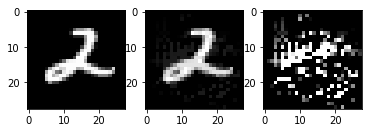

In [163]:
index = np.random.randint(60000)
inX = train_data.train_data[index]
trueY = train_data.train_labels[index].item()
targetY = np.random.randint(10)
targetY = (targetY+1)%10 if targetY == trueY else targetY
adX = adversarial_v1(inX,targetY,net,criterion,500)
predY = net(adX+inX.unsqueeze(0)).max(1)[1].item()

print("Pred label:",predY)
print("Target label:",targetY)
print("True label:",trueY)
print("L2 norm:",t.sqrt((adX**2).sum()).item())

pic1 = inX.cpu().numpy().reshape(28,28)
mpl.subplot(131)
mpl.imshow(pic1,cmap = 'gray')
pic2 = adX+inX.unsqueeze(0)
pic2 = pic2.squeeze(0).cpu().detach().numpy().reshape(28,28)
mpl.subplot(132)
mpl.imshow(pic2,cmap = 'gray')
pic3 = pic2-pic1
mpl.subplot(133)
mpl.imshow(pic3,cmap = 'gray')

In [125]:
def adversarial_v2(inX,targetLabel,net,criterion,iteration,lr,eps):
    inX_ = inX.unsqueeze(0)
    targetY = t.tensor(targetLabel).unsqueeze(0).long().to(device)
    adX = t.tensor(inX_.data,device = device,requires_grad = True)
    for i in range(iteration):
        predY = net(adX)
        loss = criterion(predY,targetY)
        net.zero_grad()
        if adX.grad is not None:
            adX.grad.data.fill_(0)
        loss.backward()
        adX = adX-lr*t.sign(adX.grad)
        adX = t.where(adX>inX_+eps,inX_+eps,adX)
        adX = t.where(adX<inX_-eps,inX_-eps,adX)
        adX = t.clamp(adX,0,255)
        adX = t.tensor(adX.data,device = device,requires_grad = True)

    return adX

In [142]:
total_size = 100
success_times = 0
for i in range(total_size):
    inX = train_data.train_data[i]
    trueY = train_data.train_labels[i].item()
    targetY = np.random.randint(10)
    if trueY == targetY:
        targetY = (targetY+1)%10
    adX = adversarial_v2(inX,targetY,net,criterion,500,1,25)
    output = net(adX)
    predY = output.max(1)[1].item()
    if predY != trueY:
        success_times += 1 
    if i%10 == 9:
        print("Epoch {} success rate: {}.".format(i+1,success_times/(i+1)))

Epoch 10 success rate: 0.5.
Epoch 20 success rate: 0.55.
Epoch 30 success rate: 0.5666666666666667.
Epoch 40 success rate: 0.5.
Epoch 50 success rate: 0.48.
Epoch 60 success rate: 0.48333333333333334.
Epoch 70 success rate: 0.4714285714285714.
Epoch 80 success rate: 0.475.
Epoch 90 success rate: 0.4666666666666667.
Epoch 100 success rate: 0.45.


Pred label: 8
Target label: 8
True label: 1
L2 norm: 478.79327392578125


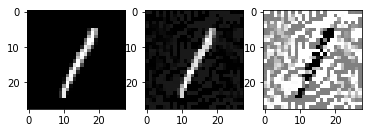

In [169]:
index = np.random.randint(60000)
inX = train_data.train_data[index]
trueY = train_data.train_labels[index].item()
targetY = np.random.randint(10)
targetY = (targetY+1)%10 if targetY == trueY else targetY
adX = adversarial_v2(inX,targetY,net,criterion,500,1,25)
predY = net(adX).max(1)[1].item()

print("Pred label:",predY)
print("Target label:",targetY)
print("True label:",trueY)
print("L2 norm:",t.sqrt(((adX-inX)**2).sum()).item())

pic1 = inX.cpu().numpy().reshape(28,28)
mpl.subplot(131)
mpl.imshow(pic1,cmap = 'gray')
pic2 = adX.cpu().detach().numpy().reshape(28,28)
mpl.subplot(132)
mpl.imshow(pic2,cmap = 'gray')
pic3 = pic2-pic1
mpl.subplot(133)
mpl.imshow(pic3,cmap = 'gray')